## RetinaNet

Link to the paper: https://arxiv.org/pdf/1708.02002.pdf

In [1]:
from fastai.conv_learner import *
from matplotlib import patches, patheffects

## Loading the relevant files

In [2]:
coco_path = Path('/scratch/arka/Ark_git_files/coco/')
ann_path = coco_path / 'annotations'
train_path = coco_path / 'train2017'
val_path = coco_path / 'val2017'

In [ ]:
!ls {ann_path}

In [3]:
captions_train2017 = json.load((ann_path / 'captions_train2017.json').open('r'))
captions_val2017 = json.load((ann_path / 'captions_val2017.json').open('r'))
instances_train2017 = json.load((ann_path / 'instances_train2017.json').open('r'))
instances_val2017 = json.load((ann_path / 'instances_val2017.json').open('r'))
person_keypoints_train2017 = json.load((ann_path / 'person_keypoints_train2017.json').open('r'))
person_keypoints_val2017 = json.load((ann_path / 'person_keypoints_val2017.json').open('r'))

In [ ]:
instances_train2017.keys()

In [ ]:
'{:012}'.format(instances_train2017['annotations'][0]['image_id']) + '.jpg'

### Saving relevant files

In [ ]:
train_df_list = []
# print(instances_train2017['annotations'][0]['image_id'])
# instances_train2017['annotations'][0]['id']
for d in tqdm(instances_train2017['annotations']):
    iid = d['id']
    image_id = d['image_id']
    bbox = d['bbox']
    cat_id = d['category_id']
    train_df_list.append([iid, image_id, bbox, cat_id])
train_df = pd.DataFrame(train_df_list, columns=['id','image_id', 'bbox', 'category_id'])

In [ ]:
val_df_list = []
# print(instances_train2017['annotations'][0]['image_id'])
# instances_train2017['annotations'][0]['id']
for d in tqdm(instances_val2017['annotations']):
    iid = d['id']
    image_id = d['image_id']
    bbox = d['bbox']
    cat_id = d['category_id']
    val_df_list.append([iid, image_id, bbox, cat_id])
val_df = pd.DataFrame(val_df_list, columns=['id','image_id', 'bbox', 'category_id'])

In [4]:
CSVS = coco_path / 'CSVS'
CSVS.mkdir(exist_ok=True)

train_csv = CSVS / 'train.csv'
val_csv = CSVS / 'val.csv'

category_mapping = coco_path / 'category_map.json'
inv_category_mapping = coco_path / 'inv_category_map.json'

In [ ]:
train_df.to_csv(train_csv, header=True, index=False)
val_df.to_csv(val_csv, header=True, index=False)

In [ ]:
cmap = dict()
inv_cmap = dict()
for i in instances_train2017['categories']:
    cmap[i['id']] = i['name']
    inv_cmap[i['name']] = i['id']

In [ ]:
json.dump(cmap, category_mapping.open('w'))
json.dump(inv_cmap, inv_category_mapping.open('w'))

### Loading relevant files

In [5]:
train_df = pd.read_csv(train_csv, header='infer')
val_df = pd.read_csv(val_csv, header='infer')
cat_map = json.load(category_mapping.open('r'))
inv_cat_map = json.load(inv_category_mapping.open('r'))

### Creating Dataset and Dataloader

In [ ]:
??BaseDataset

In [6]:
catlist = []
cat2lab = dict()
lab2cat = dict()
c = 0
for i, v in cat_map.items():
    catlist.append(int(i))
    cat2lab[int(i)] = c
    lab2cat[c] = int(i)
    c += 1

In [7]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [33]:
import ast
class CocoDS(BaseDataset):
    def __init__(self, df, tdir, sz=224, tfm1=None):
        # ['id', 'image_id', 'bbox', 'category_id']
        self.df = df
        self.tdir = tdir        
        self.n = self.get_n()
        self.c = self.get_c()
        self.sz = sz
        # tfm1 for bbox
        self.tfm1 = tfm1
        
    def get_n(self):
        return len(self.df)
    
    def get_c(self):
        return 80
    
    def get_sz(self):
        return self.sz
    
    def get_x(self, i):
        fid = '{:012}'.format(self.df.iloc[i]['image_id']) + '.jpg'
        fname = self.tdir / fid
        return open_image(fname)
    
    def get_y(self, i):
        y_bbox = self.df.iloc[i]['bbox']
        cat_id = self.df.iloc[i]['category_id']
        y_id = cat2lab[cat_id]
        y_bbox = ast.literal_eval(y_bbox)
        return hw_bb(np.array(y_bbox)), y_id
    
    def get1item(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        x, y1 = self.tfm1(x, y[0])
        return x, (y1, y[1])
    
    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.
        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.tfm1.denorm(np.rollaxis(arr,1,4))

In [70]:
imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
sz = 224
# tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_basic, tfm_y=TfmType.COORD)
bs = 9
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
trn_ds = CocoDS(train_df, train_path, sz, tfms[0])
trn_dl = DataLoader(trn_ds, batch_size=bs)
val_ds = CocoDS(val_df, val_path, sz, tfms[1])
val_dl = DataLoader(val_ds, batch_size=bs)

## Checking if everything is correct

In [35]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
def draw_text(ax, xy, txt, sz=10):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

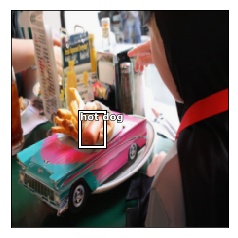

In [71]:
i = 0
ax = show_img(trn_ds.denorm(x)[i])
im0_a = [k[i] for k in y]
b = bb_hw(im0_a[0])
draw_rect(ax, b)
# draw_text(ax, b[:2], 'dog')
draw_text(ax, b[:2], cat_map[str(lab2cat[im0_a[1].cpu().numpy().item()])])

In [72]:
y

[tensor([[105.,  71., 140.,  96.],
         [148.,  82., 164., 133.],
         [162.,  85., 187., 139.],
         [  0.,   0.,   0.,   0.],
         [156.,  88., 164., 131.],
         [115., 119., 143., 140.],
         [115.,  96., 154., 118.],
         [114., 114., 195., 200.],
         [ 89.,  91., 105., 113.]], device='cuda:0'),
 tensor([52, 52, 52, 52, 52, 16, 16, 16, 16], device='cuda:0')]

In [73]:
y1

[tensor([105.,  71., 140.,  96.], device='cuda:0'),
 tensor(52, device='cuda:0')]

[ 71. 105.  24.  34.]
[128.  98.  27.  38.]
[128. 105.  25.  34.]
[68. 92. 29. 41.]
[67. 84. 31. 44.]
[ 72. 115.  31.  46.]
[126. 108.  27.  39.]
[ 71. 105.  24.  34.]
[ 71. 106.  25.  35.]


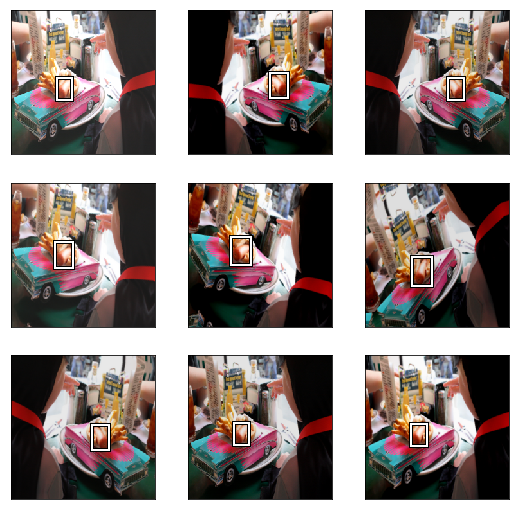

In [74]:
idx=0
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(trn_dl))
    ima=trn_ds.denorm(to_np(x))[idx]
    y1 = [k[idx] for k in y]
    b = bb_hw(to_np(y1[0]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)